In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets

import torchvision.models as models
import torchvision.transforms as transforms

In [46]:
batch_size = 1 #batch size
cuda = True

In [47]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [48]:
evalset = torchvision.datasets.ImageFolder(root = "Images_New", transform = transform)
evalloader = torch.utils.data.DataLoader(evalset, batch_size = batch_size, shuffle = True)

In [49]:
dataiter = iter(evalloader)
images, labels = dataiter.next()

print(images.shape)

torch.Size([1, 3, 224, 224])


In [50]:
def imshow(img, title):
  """Custom function to display the image using matplotlib"""
  std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  if cuda: img = img.cpu()
  npimg = np.multiply(img.numpy(), std_correction) + mean_correction
  
  #plot the numpy image
  plt.figure(figsize = (batch_size * 4, 4))
  plt.axis("off")
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [51]:
def show_batch_images(dataloader,model):
  """custom function to fetch images from dataloader"""

  images,_ = next(iter(dataloader))
  if cuda: images = images.cuda()
  
  #run the model on the images
  outputs = model(images)
  if cuda: outputs = outputs.cpu()
  
  #get the maximum class 
  _, pred = torch.max(outputs.data, 1)
  print(pred)
  
  #make grid
  img = torchvision.utils.make_grid(images)
  
  #call the function
  imshow(img, title="Image")
  
  return images, pred

In [52]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
    """custom function to conduct occlusion experiments"""
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            if cuda: input_image = input_image.cuda()
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

In [53]:
model = torch.load("fc_m")
model.eval()
if cuda: images = images.cuda()
outputs = model(images)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

print(prob_no_occ)

0.6403010487556458


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([2])


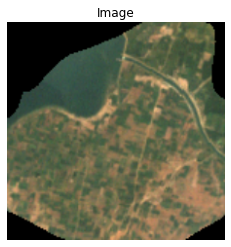

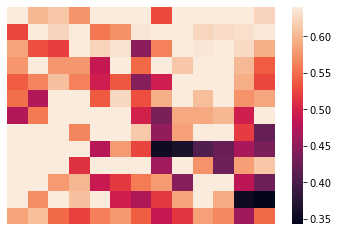

In [54]:
images, pred = show_batch_images(evalloader,model)
heatmap = occlusion(model, images, pred[0].item(), 32, 15)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure()    
figure.savefig('svm_conf.png', dpi=400)

In [39]:
import cv2
img = cv2.imread("Images_New/1/Landsat7_SR_AndhraPradesh_1999_final-0000000000-0000000000@2017400@2816001902017400@589173.png")
heatmap_img = cv2.applyColorMap(heatmap.numpy(), cv2.COLORMAP_JET)
fin = cv2.addWeighted(heatmap_img, 0.7, images, 0.3, 0)

error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'operator()'


In [40]:
type(heatmap.numpy())

numpy.ndarray